In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith('1.8.1')
pyro.set_rng_seed(0)

In [4]:
from scipy.stats import gaussian_kde # for density plots later

In [5]:
import pandas as pd
df = pd.read_csv('/Users/victorlhoste/Desktop/Local_PhD/NHANES/Data/data_pyro.csv', index_col=0)
df.head()

,height,bmi,WHtR,hba1c,hdl,non_hdl,sbp,dbp,eGFR,age_group
1,178.8,25.524376,0.496644,5.3,0.9842,5.9570,117,59,95.625163,Young
2,162.2,23.433188,0.557953,4.6,1.4245,2.7195,130,88,114.670330,Young
3,156.9,27.642813,0.570427,5.3,1.7094,4.4030,134,75,87.324169,Middage
4,177.4,29.392363,0.576099,4.6,1.1137,4.7138,135,94,77.957926,Young
5,168.2,24.954721,0.558859,9.1,1.3209,5.4131,121,69,79.104629,Middage


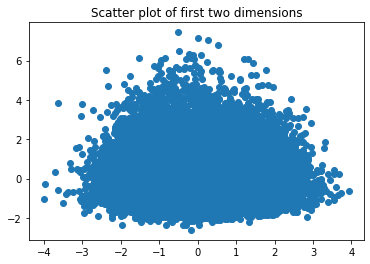

In [6]:
df =df[["height","bmi"]]

df_centered = df.apply(lambda x: (x - x.mean())/x.std() )
#print(df_centered)
data=torch.tensor(df_centered.values)
data=data.float() # necessary for the code to run
#data = torch.tensor([0., 1., 10., 11., 12.])
#data=transforms.normalize(data)
plt.scatter(data[:, 0],data[:, 1])
plt.title("Scatter plot of first two dimensions")
plt.show()

In [7]:
# stick breaking process

def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

In [8]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(2)), obs=data)

In [9]:
def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))

100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


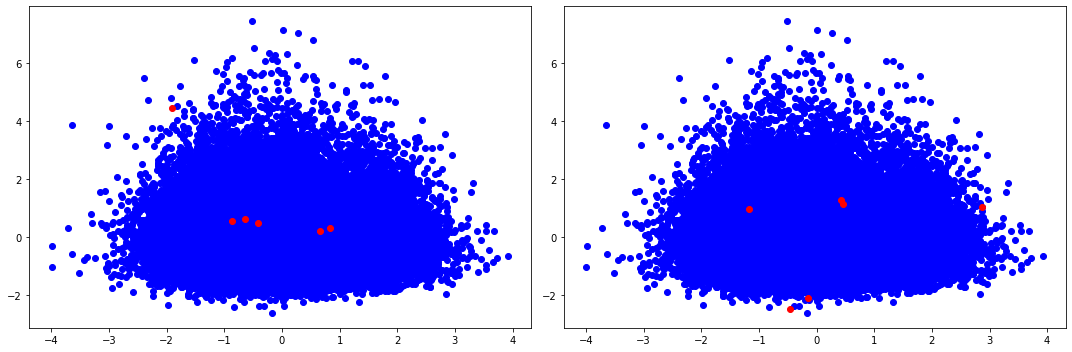

In [10]:
N=data.shape[0]
T = 6
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 0.1
train(10)
Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

alpha = 1.5
train(10)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
plt.tight_layout()
plt.show()


In [12]:
xy = np.vstack([data[:, 0],data[:, 1]])
z = gaussian_kde(xy)(xy)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], c=z)
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], color=z)
plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
plt.tight_layout()
plt.show()